In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch

In [2]:
df_data = pd.read_csv("dataset_phishing.csv")
df_data.shape

(11430, 89)

In [3]:
df_data.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [4]:
#Encoding 'status' as label 1 & 0 , naming the field as target
df_data['target'] = pd.get_dummies(df_data['status'])['legitimate'].astype('int')
df_data.drop('status',axis = 1, inplace=True)
df_data[['url','target']].head(5)

,url,target
0,http://www.crestonwood.com/router.php,1
1,http://shadetreetechnology.com/V4/validation/a...,0
2,https://support-appleld.com.secureupdate.duila...,0
3,http://rgipt.ac.in,1
4,http://www.iracing.com/tracks/gateway-motorspo...,1


In [5]:
tmp = df_data.isnull().sum().reset_index(name='missing_val')
tmp[tmp['missing_val']!= 0]

,index,missing_val


In [6]:
likely_cat = {}
for var in df_data.iloc[:,1:].columns:
    likely_cat[var] = 1.*df_data[var].nunique()/df_data[var].count() < 0.002 

num_cols = []
cat_cols = []
for col in likely_cat.keys():
    if (likely_cat[col] == False):
        num_cols.append(col)
    else:
        cat_cols.append(col)

In [8]:
#Train & Test Set
X= df_data.iloc[: , 1:-1]
#y = upsampled_df['Churn']
y= df_data['target']

train_x,test_x,train_y,test_y = train_test_split(X,y,random_state=42)
print("\n--Training data samples--")
print(train_x.shape)


--Training data samples--
(8572, 87)


In [10]:
###First use a MinMaxscaler to scale all the features of Train & Test dataframes
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
x_train = scaler.fit_transform(train_x.values)
x_test =  scaler.fit_transform(test_x.values)

print("Scaled values of Train set \n")
print(x_train)
print("\nScaled values of Test set \n")
print(x_test)


###Then convert the Train and Test sets into Tensors

x_tensor =  torch.from_numpy(x_train).float()
y_tensor =  torch.from_numpy(train_y.values.ravel()).float()
xtest_tensor =  torch.from_numpy(x_test).float()
ytest_tensor =  torch.from_numpy(test_y.values.ravel()).float()

print("\nTrain set Tensors \n")
print(x_tensor)
print(y_tensor)
print("\nTest set Tensors \n")
print(xtest_tensor)
print(ytest_tensor)

Scaled values of Train set 

[[0.0650706  0.18095238 1.         ... 0.         1.         0.        ]
 [0.04297115 0.06190476 0.         ... 0.         0.         0.6       ]
 [0.07550645 0.06190476 1.         ... 0.         0.         0.5       ]
 ...
 [0.01473297 0.07619048 0.         ... 0.         1.         0.2       ]
 [0.00859423 0.06190476 0.         ... 0.         1.         0.2       ]
 [0.02823818 0.06190476 0.         ... 0.         1.         0.5       ]]

Scaled values of Test set 

[[0.03571429 0.04       0.         ... 0.         0.         0.5       ]
 [0.01461039 0.06285714 0.         ... 0.         0.         0.2       ]
 [0.0487013  0.06285714 0.         ... 0.         0.         1.        ]
 ...
 [0.24350649 0.08571429 0.         ... 0.         1.         0.        ]
 [0.01461039 0.06285714 0.         ... 0.         0.         0.3       ]
 [0.09577922 0.04571429 0.         ... 0.         0.         0.4       ]]

Train set Tensors 

tensor([[0.0651, 0.1810, 1.0000, 

In [11]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

#Define a batch size , 
bs = 64
#Both x_train and y_train can be combined in a single TensorDataset, which will be easier to iterate over and slice
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
#Pytorch’s DataLoader is responsible for managing batches. 
#You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches
train_dl = DataLoader(train_ds, batch_size=bs)


#For the validation/test dataset
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_ds, batch_size=32)

In [12]:
from torch import nn

n_input_dim = train_x.shape[1]

#Layer size
n_hidden1 = 300  # Number of hidden nodes
n_hidden2 = 100
n_output =  1   # Number of output nodes = for binary classifier


class ChurnModel(nn.Module):
    def __init__(self):
        super(ChurnModel, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, n_hidden1) 
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = nn.Linear(n_hidden2, n_output) 
        
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        
        return x
    

model = ChurnModel()
print(model)

ChurnModel(
  (layer_1): Linear(in_features=87, out_features=300, bias=True)
  (layer_2): Linear(in_features=300, out_features=100, bias=True)
  (layer_out): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [13]:
#Loss Computation
loss_func = nn.BCELoss()
#Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50

In [15]:
from tqdm import tqdm

model.train()
train_loss = []
for epoch in tqdm(range(epochs)):
    #Within each epoch run the subsets of data = batch sizes.
    for xb, yb in train_dl:
        y_pred = model(xb)            # Forward Propagation
        loss = loss_func(y_pred, yb)  # Loss Computation
        optimizer.zero_grad()         # Clearing all previous gradients, setting to zero 
        loss.backward()               # Back Propagation
        optimizer.step()              # Updating the parameters 
    #print("Loss in iteration :"+str(epoch)+" is: "+str(loss.item()))
    train_loss.append(loss.item())
print('Last iteration loss value: '+str(loss.item()))

100%|██████████| 50/50 [00:14<00:00,  3.56it/s]

Last iteration loss value: 6.001920610287925e-06


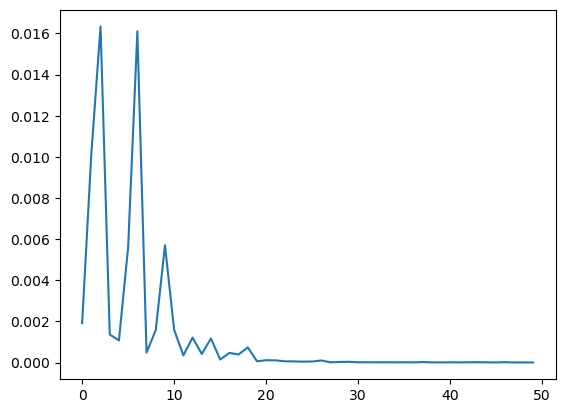

In [17]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.show()

In [18]:
import itertools

y_pred_list = []
model.eval()
#Since we don't need model to back propagate the gradients in test set we use torch.no_grad()
# reduces memory usage and speeds up computation
with torch.no_grad():
    for xb_test,yb_test  in test_loader:
        y_test_pred = model(xb_test)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.detach().numpy())

#Takes arrays and makes them list of list for each batch        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
#flattens the lists in sequence
ytest_pred = list(itertools.chain.from_iterable(y_pred_list))

In [19]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

y_true_test = test_y.values.ravel()
conf_matrix = confusion_matrix(y_true_test ,ytest_pred)
print("Confusion Matrix of the Test Set")
print("-----------")
print(conf_matrix)
print("Precision of the MLP :\t"+str(precision_score(y_true_test,ytest_pred)))
print("Recall of the MLP    :\t"+str(recall_score(y_true_test,ytest_pred)))
print("F1 Score of the Model :\t"+str(f1_score(y_true_test,ytest_pred)))

Confusion Matrix of the Test Set
-----------
[[1389   47]
 [ 126 1296]]
Precision of the MLP :	0.9650037230081906
Recall of the MLP    :	0.9113924050632911
F1 Score of the Model :	0.9374321880650994


In [20]:
from sklearn.metrics import accuracy_score
print("Accuracy of the MLP Model :\t"+str(accuracy_score(y_true_test,ytest_pred)))

Accuracy of the MLP Model :	0.9394681595521344
